In [13]:
## These are stretching model functions

import DiadFit as pf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
pf.__version__

## These are functions to find the pressure corresponding to a specific depth using a DiadFit models 

from scipy.optimize import newton

def pressure_equation(P_kbar, target_depth, model):
    current_depth = pf.convert_pressure_to_depth(P_kbar=P_kbar, model=model)[0]
    return current_depth - target_depth

def find_P_for_kmdepth(target_depth, model, tolerance=0.1):
    initial_pressure = 0  
    pressure = newton(pressure_equation, initial_pressure, args=(target_depth, model), tol=tolerance)
    return pressure

## Example: find the pressure at 5 km depth

target_depth = 5  
model = 'ryan_lerner'
tolerance = 0.001  # how close you want to be

# run it
pressure = find_P_for_kmdepth(target_depth, model, tolerance)
# print the result
print("Pressure:", pressure)
print("Depth:", pf.convert_pressure_to_depth(P_kbar=pressure, model=model)[0])

Pressure: 1.1834708907085945
Depth: 4.999999838702872


In [21]:


class config_crustalmodel:
    def __init__(self, crust_dens_kgm3=None,
                 d1=None, d2=None, rho1=None, rho2=None, rho3=None, model=None):
        self.crust_dens_kgm3 = crust_dens_kgm3
        self.d1 = d1
        self.d2 = d2
        self.rho1 = rho1
        self.rho2 = rho2
        self.rho3 = rho3
        self.model = model

def objective_function_depth(P_kbar, target_depth, crust_dens_kgm3,
                            d1, d2, rho1, rho2, rho3, model):
    """
    Calculate the difference between the current depth and the target depth
    given pressure (P_kbar) and other parameters.

    Parameters:
    - P_kbar (float): The pressure in kilobars (kbar) to be used in the depth calculation.
    - target_depth (float): The desired depth in kilometers (km).
    - crust_dens_kgm3 (float): The density of the crust in kilograms per cubic meter (kg/m^3).
    - d1, d2 (float): Depth boundaries for different layers (km).
    - rho1, rho2, rho3 (float): Densities for different layers (kg/m^3).
    - model (str): The name of the model used for the depth calculation.

    Returns:
    - float: The difference between the current depth and the target depth.
    """

    current_depth = pf.convert_pressure_to_depth(P_kbar=P_kbar, crust_dens_kgm3=crust_dens_kgm3, g=9.81,
                                              d1=d1, d2=d2, rho1=rho1, rho2=rho2, rho3=rho3, model=model)[0]

    return current_depth - target_depth

def find_P_for_kmdepth(target_depth, config=config_crustalmodel(), initial_P_guess=0,tolerance=0.1):
    """
    Approximate the pressure (P_kbar) based on the target depth using the Newton-Raphson method.

    Parameters:
    - target_depth (float): The desired depth in kilometers (km).
    - P_kbar (float, optional): Initial guess for the pressure in kilobars (kbar). Default is None.
    - crust_dens_kgm3 (float, optional): The density of the crust in kilograms per cubic meter (kg/m^3). Default is None.
    - d1, d2 (float, optional): Depth boundaries for different layers (km). Default is None.
    - rho1, rho2, rho3 (float, optional): Densities for different layers (kg/m^3). Default is None.
    - model (str, optional): The name of the model used for the depth calculation. Default is None.
    - tolerance (float, optional): How close the pressure estimate should be to the true value. Default is 0.1.

    Returns:
    - float: The estimated pressure (P_kbar) that corresponds to the target depth.
    """

    if all(v is None for v in [config.crust_dens_kgm3, config.d1, config.d2, config.rho1, config.rho2, config.rho3, config.model]):
        config.crust_dens_kgm3 = 2750
        warnings.warn("No crustal parameters were provided, setting crust_dens_kgm3 to 2750. Please use config_crustalmodel(...) to set your desired crustal model parameters.", UserWarning)

    pressure = newton(objective_function_depth, initial_P_guess, args=(target_depth, config.crust_dens_kgm3, config.d1, config.d2, config.rho1, config.rho2, config.rho3, config.model), tol=tolerance)
    return pressure

## Example: find the pressure at 5 km depth

target_depth = 5  
config=config_crustalmodel()
tolerance = 0.001  # how close you want to be

# run it
pressure = find_P_for_kmdepth(target_depth=5, config=config, tolerance=tolerance)
print("Pressure:", pressure)


Pressure: 1.3488749999999998


C:\Users\charl\AppData\Local\Temp\ipykernel_29612\539521163.py:63: UserWarning: No crustal parameters were provided, setting crust_dens_kgm3 to 2750. Please use config_crustalmodel(...) to set your desired crustal model parameters.
  warnings.warn("No crustal parameters were provided, setting crust_dens_kgm3 to 2750. Please use config_crustalmodel(...) to set your desired crustal model parameters.", UserWarning)


In [7]:
## Functions that do the work

# Calculating density using ideal gas law for sphere of radius r, P in MPa, T in K. 
def ideal_calc_rho_for_r_P_T(*,P_MPa,T,r):
    P=P_MPa*10**6 # convert MPa to Pa
    M=44.01/1000 #kg/mol
    V=4/3*math.pi*r**3 #m3
    R=8.314 #J.mol/K J: kg·m²/s² 
    m=P*V*M/(R*T) #CO2 mass in kg
    rho=(m/V)/1000 # rho in g/cm3
    return rho, m/1000

# Calculating pressure using ideal gas law for sphere of radius r, CO2 mass in grams, T in K. 
def ideal_calc_P_for_V_rho_T(*,co2_mass_g,T,r):
    M=44.01/1000 #kg/mol
    m=co2_mass_g*1000
    V=4/3*math.pi*r**3 #m3
    R=8.314 #J.mol/K J: kg·m²/s² 
    P=m*R*T/(M*V) #P in Pa
    P_MPa=P/(10**6) #P in MPa
    rho=(m/V)/1000 #rho in g/cm3
    return rho,P_MPa


def calculate_DPdt(ascent_rate_ms,D_initial=30,D_final=0,D_step=100):
    D = pd.Series(list(np.linspace(D_initial, D_final, D_step)))  # km

    h = D * 10 ** 3  # m
    rho = 3058  # kg/m3
    g = 9.81  # m/s2
    P = rho * g * h * 10 ** -6  # MPa lithostatic pressure
    Pexternal_steps = list(P)  # These are the pressure steps

    # Time steps of the ascent
    ascent_rate = ascent_rate_ms / 1000  # km/s
    D_change = abs(D.diff())
    time_series = D_change / ascent_rate  # calculates the time in between each step based on ascent rate
    dt = time_series.max()  # this sets the time step for the integration part
    
    return D, Pexternal_steps, dt

def calculate_initial_V_CO2rho_mass(*,EOS='SW96',P,T,r):
    ### This function calculates CO2 mass as a function of P,T, and FI radius(Volume), r has to be in cm,
    ### V is output in cm3, rho in g/cm3 and mass in g
    ###
    V=4/3*math.pi*r**3 #cm3, Volume of the FI, assume sphere
    P_kbar=P/100 #Internal pressure of the FI
    CO2_dens=pf.calculate_rho_for_P_T(EOS=EOS,P_kbar=P_kbar,T_K=T)[0] #g/cm3, CO2 density, calc by Span&Wagner(96)
    CO2_mass=CO2_dens*V # this is our CO2 mass in the FI
    return V, CO2_dens, CO2_mass

def calculate_step_P_for_m_r(*,EOS='SW96',m,T,r):
    ### This function internal pressure and volume of the inclusion as a function of T, FI radius and CO2 mass, r has to be in cm,
    ### V is output in cm3, rho in g/cm3 and mass in g.
    ###
    V=4/3*math.pi*r**3 #cm3, Volume of the FI, assume sphere
    CO2_dens=m/V
    try:
        P_new=pf.calculate_P_for_rho_T(EOS=EOS,CO2_dens_gcm3=CO2_dens, T_K=T)['P_MPa'][0] #g/cm3, CO2 density, calc by Span&Wagner(96)
        return V, CO2_dens, P_new
    except ValueError:
        return V,CO2_dens,np.nan


class power_creep_law_constants:
    def __init__(self):
        self.A = 3.9*10**3 #7.0 * 10**4
        self.n = 3.6 #3
        self.Q = 523000 # 520 Activation energy for dislocation motions in J/mol
        self.IgasR= 8.314  # Gas constant in J/(mol*K)

# # Helper function to calculate dR/dt
def calculate_dR_dt(*,R, b, T,  Pinternal, Pexternal):
    pl_Cs = power_creep_law_constants()
    if Pinternal<Pexternal==True:
        S=-1
    else:
        S=1
    try:
        dR_dt = 2 * (S * pl_Cs.A * math.exp(-pl_Cs.Q / (pl_Cs.IgasR * T))) * (((R * b)**3) / (((b**(3 / pl_Cs.n)) - (R**(3 / pl_Cs.n))))**pl_Cs.n) * (((3 * abs(Pinternal - Pexternal)) / (2 * pl_Cs.n))**pl_Cs.n) / R**2
        return dR_dt

    except FloatingPointError:
        return np.nan

# Euler method for iterative numerical solving (range of Pext)
def findR_Pi_rho_4Pestep_euler(*,R0, b, T,D,Pexternal_steps,dt,EOS,plotfig=True,display_df=True,Pinternal=None):
    if Pinternal is None:
        Pinternal = Pexternal_steps[0]
    _,CO2_dens_initial,CO2_mass_initial=calculate_initial_V_CO2rho_mass(EOS=EOS,P=Pinternal,T=T,r=R0*10**2)
    R_values = [R0]  # List to store R values at different time points
    Pinternal_list=[Pinternal]
    CO2_dens_list=[CO2_dens_initial]
    dR_dt_list=[]
    results=pd.DataFrame(columns={'Pexternal(MPa)','Pinternal(MPa)',
                                  'Depth(km)','Fi_radius(\u03BCm)',
                                  'CO2_dens_gcm3','dR/dt(m/s)' })
    for i in range(len(Pexternal_steps)):
        Pexternal = Pexternal_steps[i]
        dR_dt = calculate_dR_dt(R=R_values[-1], b=b,Pinternal=Pinternal, Pexternal=Pexternal, T=T)
        R_new = R_values[-1] + dR_dt * dt
        _,CO2_dens_new,P_new=calculate_step_P_for_m_r(EOS=EOS,m=CO2_mass_initial,T=T,r=R_new*10**2)
        Pinternal=P_new
        dR_dt_list.append(dR_dt)
        R_values.append(R_new)
        Pinternal_list.append(Pinternal)
        CO2_dens_list.append(CO2_dens_new)
    
    results['Pexternal(MPa)']=Pexternal_steps
    results['Pinternal(MPa)']=Pinternal_list[1:]
    results['Depth(km)']=D
    results['Fi_radius(\u03BCm)']=[num * 10**6 for num in R_values][1:]
    results['CO2_dens_gcm3']=CO2_dens_list[1:]
    results['dR/dt(m/s)']=dR_dt_list
    results['\u0394R/R0']=(results['Fi_radius(μm)']-results['Fi_radius(μm)'][0])/results['Fi_radius(μm)'][0]

    if display_df==True:
        display(results.head())
    if plotfig==True:
        fig, (ax0,ax1) = ax.subplots(1,2, figsize=(10,3))
        ax0.plot(-results['Depth(km)'],results['ΔR/R0'],marker='s')
        ax0.set_xlabel("Depth")
        ax0.set_ylabel("DeltaR/R0")

        ax1.plot(-results['Depth(km)'],results['CO2_dens_gcm3'],marker='s')
        ax1.set_xlabel("Depth")
        ax1.set_ylabel("CO2_density_gmL")

    return results, fig if 'fig' in locals() else results

def findR_Pi_rho_fixedPe_euler(*,R,b=None,T,EOS_method=None,EOS='SW96',Pinternal,Pexternal,totaltime,steps):

    dt=totaltime/steps

    if b is None:
        b=R*1000
    
    if EOS_method=='ideal':
        CO2_dens_initial,CO2_mass_initial=ideal_calc_rho_for_r_P_T(P_MPa=Pinternal,T=T,r=R*10**2)
    else:
        _,CO2_dens_initial,CO2_mass_initial=calculate_initial_V_CO2rho_mass(EOS=EOS,P=Pinternal,T=T,r=R*10**2)

    results = pd.DataFrame([{'Time(s)': 0,
                             'Step':0,
                             'dt(s)':0,
                            'Pexternal(MPa)': Pexternal,
                            'Pinternal(MPa)': Pinternal,
                            'dR/dt(m/s)': calculate_dR_dt(R=R, b=b, Pinternal=Pinternal, Pexternal=Pexternal, T=T),
                            'Fi_radius(μm)': R*10**6,
                            'b (distance to xtal rim -μm)':b*10**6,
                            '\u0394R/R0 (fractional change in radius)':0,
                            'CO2_dens_gcm3': CO2_dens_initial}], index=range(steps))

    for step in range(1,steps):
        dR_dt = calculate_dR_dt(R=R, b=b,Pinternal=Pinternal, Pexternal=Pexternal, T=T)
        R_new= R + dR_dt*dt
        if EOS_method=='ideal':
            CO2_dens_new,P_new=ideal_calc_P_for_V_rho_T(co2_mass_g=CO2_mass_initial,T=T,r=R_new*10**2)
        else:
            _,CO2_dens_new,P_new=calculate_step_P_for_m_r(EOS=EOS,m=CO2_mass_initial,T=T,r=R_new*10**2)
        R=R_new
        #b=1000*R
        Pinternal=P_new

        results.loc[step,'Time(s)']=step*dt
        results.loc[step,'Step']=step
        results.loc[step,'dt(s)']=dt
        results.loc[step,'Pexternal(MPa)']=Pexternal
        results.loc[step,'Pinternal(MPa)']=Pinternal
        results.loc[step,'dR/dt(m/s)']=dR_dt
        results.loc[step,'Fi_radius(μm)']=R*10**6
        results.loc[step,'\u0394R/R0 (fractional change in radius)']=(R*10**6-results.loc[0,'Fi_radius(μm)'])/results.loc[0,'Fi_radius(μm)']
        results.loc[step,'b (distance to xtal rim -μm)']=b*10**6
        results.loc[step,'CO2_dens_gcm3']=CO2_dens_new
    return results


def findR_Pi_rho_fixedPe(*,R,b=None,T,EOS_method=None,EOS='SW96',Pinternal,Pexternal,totaltime,steps,int_method='Euler'):

    dt=totaltime/steps

    if b is None:
        b=R*1000
    
    if EOS_method=='ideal':
        CO2_dens_initial,CO2_mass_initial=ideal_calc_rho_for_r_P_T(P_MPa=Pinternal,T=T,r=R*10**2)
    else:
        _,CO2_dens_initial,CO2_mass_initial=calculate_initial_V_CO2rho_mass(EOS=EOS,P=Pinternal,T=T,r=R*10**2)

    results = pd.DataFrame([{'Time(s)': 0,
                             'Step':0,
                             'dt(s)':0,
                            'Pexternal(MPa)': Pexternal,
                            'Pinternal(MPa)': Pinternal,
                            'dR/dt(m/s)': calculate_dR_dt(R=R, b=b, Pinternal=Pinternal, Pexternal=Pexternal, T=T),
                            'Fi_radius(μm)': R*10**6,
                            'b (distance to xtal rim -μm)':b*10**6,
                            '\u0394R/R0 (fractional change in radius)':0,
                            'CO2_dens_gcm3': CO2_dens_initial}], index=range(steps))

    if int_method=='Euler':
        for step in range(1,steps):
            dR_dt = calculate_dR_dt(R=R, b=b,Pinternal=Pinternal, Pexternal=Pexternal, T=T)
            R_new= R + dR_dt*dt
            if EOS_method=='ideal':
                CO2_dens_new,P_new=ideal_calc_P_for_V_rho_T(co2_mass_g=CO2_mass_initial,T=T,r=R_new*10**2)
            else:
                _,CO2_dens_new,P_new=calculate_step_P_for_m_r(EOS=EOS,m=CO2_mass_initial,T=T,r=R_new*10**2)
            R=R_new
            b=1000*R
            Pinternal=P_new
            
            results.loc[step,'Time(s)']=step*dt
            results.loc[step,'Step']=step
            results.loc[step,'dt(s)']=dt
            results.loc[step,'Pexternal(MPa)']=Pexternal
            results.loc[step,'Pinternal(MPa)']=Pinternal
            results.loc[step,'dR/dt(m/s)']=dR_dt
            results.loc[step,'Fi_radius(μm)']=R*10**6
            results.loc[step,'\u0394R/R0 (fractional change in radius)']=(R*10**6-results.loc[0,'Fi_radius(μm)'])/results.loc[0,'Fi_radius(μm)']
            results.loc[step,'b (distance to xtal rim -μm)']=b*10**6
            results.loc[step,'CO2_dens_gcm3']=CO2_dens_new

    if int_method=='RK4':

        for step in range(1, steps):
            # Calculate k1
            dR_dt = calculate_dR_dt(R=R, b=b, Pinternal=Pinternal, Pexternal=Pexternal, T=T)
            k1 = dR_dt * dt

            # Calculate k2
            R_temp = R + 0.5 * k1
            if EOS_method == 'ideal':
                CO2_dens_temp, P_temp = ideal_calc_P_for_V_rho_T(co2_mass_g=CO2_mass_initial, T=T, r=R_temp * 10**2)
            else:
                _, CO2_dens_temp, P_temp = calculate_step_P_for_m_r(EOS=EOS, m=CO2_mass_initial, T=T, r=R_temp * 10**2)
            k2 = (P_temp - Pinternal) * dt

            # Calculate k3
            R_temp = R + 0.5 * k2
            if EOS_method == 'ideal':
                CO2_dens_temp, P_temp = ideal_calc_P_for_V_rho_T(co2_mass_g=CO2_mass_initial, T=T, r=R_temp * 10**2)
            else:
                _, CO2_dens_temp, P_temp = calculate_step_P_for_m_r(EOS=EOS, m=CO2_mass_initial, T=T, r=R_temp * 10**2)
            k3 = (P_temp - Pinternal) * dt

            # Calculate k4
            R_temp = R + k3
            if EOS_method == 'ideal':
                CO2_dens_temp, P_temp = ideal_calc_P_for_V_rho_T(co2_mass_g=CO2_mass_initial, T=T, r=R_temp * 10**2)
            else:
                _, CO2_dens_temp, P_temp = calculate_step_P_for_m_r(EOS=EOS, m=CO2_mass_initial, T=T, r=R_temp * 10**2)
            k4 = (P_temp - Pinternal) * dt

            # Update R and Pinternal using the weighted average of the four k values
            R += (k1 + 2 * k2 + 2 * k3 + k4) / 6
            Pinternal = P_temp
            b=1000*R
            results.loc[step,'Time(s)']=step*dt
            results.loc[step,'Step']=step
            results.loc[step,'dt(s)']=dt
            results.loc[step,'Pexternal(MPa)']=Pexternal
            results.loc[step,'Pinternal(MPa)']=Pinternal
            results.loc[step,'dR/dt(m/s)']=dR_dt
            results.loc[step,'Fi_radius(μm)']=R*10**6
            results.loc[step,'\u0394R/R0 (fractional change in radius)']=(R*10**6-results.loc[0,'Fi_radius(μm)'])/results.loc[0,'Fi_radius(μm)']
            results.loc[step,'b (distance to xtal rim -μm)']=b*10**6
            results.loc[step,'CO2_dens_gcm3']=CO2_dens_temp

    return results

def solve_runge_kutta(*, R, b=None, T, Pinternal, Pexternal, totaltime, steps=1000, EOS_method='ideal', order=4):
    dt = totaltime / steps

    if b is None:
        b = R * 1000

    if EOS_method == 'ideal':
        CO2_dens_initial, CO2_mass_initial = ideal_calc_rho_for_r_P_T(P_MPa=Pinternal, T=T, r=R * 10 ** 2)
    else:
        _, CO2_dens_initial, CO2_mass_initial = calculate_initial_V_CO2rho_mass(EOS=EOS, P=Pinternal, T=T, r=R * 10 ** 2)

    results = pd.DataFrame(columns=['Time(s)', 'Step', 'dt(s)', 'Pexternal(MPa)', 'Pinternal(MPa)', 'dR/dt(m/s)',
                                    'Fi_radius(μm)', 'b (distance to xtal rim -μm)',
                                    'ΔR/R0 (fractional change in radius)', 'CO2_dens_gcm3'])

    results.loc[0] = [0, 0, 0, Pexternal, Pinternal, calculate_dR_dt(R=R, b=b, Pinternal=Pinternal, Pexternal=Pexternal, T=T),
                      R * 10 ** 6, b * 10 ** 6, 0, CO2_dens_initial]

    for step in range(steps):
        if order == 2:
            k1 = dt * calculate_dR_dt(R=R, b=b, T=T, Pinternal=Pinternal, Pexternal=Pexternal)
            k2 = dt * calculate_dR_dt(R=R + 0.5 * k1, b=b, T=T, Pinternal=Pinternal, Pexternal=Pexternal)

            dR_dt = ((k1 + k2) / 2) / dt
            R += (k1 + k2) / 2
        elif order == 4:
            k1 = dt * calculate_dR_dt(R=R, b=b, T=T, Pinternal=Pinternal, Pexternal=Pexternal)
            k2 = dt * calculate_dR_dt(R=R + 0.5 * k1, b=b, T=T, Pinternal=Pinternal, Pexternal=Pexternal)
            k3 = dt * calculate_dR_dt(R=R + 0.5 * k2, b=b, T=T, Pinternal=Pinternal, Pexternal=Pexternal)
            k4 = dt * calculate_dR_dt(R=R + k3, b=b, T=T, Pinternal=Pinternal, Pexternal=Pexternal)

            dR_dt = ((k1 + 2 * k2 + 2 * k3 + k4) / 6) / dt
            R += (k1 + 2 * k2 + 2 * k3 + k4) / 6

        if EOS_method == 'ideal':
            CO2_dens_temp, P_temp = ideal_calc_P_for_V_rho_T(co2_mass_g=CO2_mass_initial, T=T, r=R * 10 ** 2)
        else:
            _, CO2_dens_temp, P_temp = calculate_step_P_for_m_r(EOS=EOS, m=CO2_mass_initial, T=T, r=R * 10 ** 2)

        Pinternal = P_temp
        b = R * 1000
        results.loc[step] = [step * dt, step, dt, Pexternal, Pinternal, dR_dt, R * 10 ** 6,
                             (R * 10 ** 6 - results.loc[0, 'Fi_radius(μm)']) / results.loc[0, 'Fi_radius(μm)'],
                             b * 10 ** 6, CO2_dens_temp]
    return results

def calculate_results(R_values, b_values, T, EOS, Pinternal, Pexternal, totaltime_in_s, steps, T4endcalc_PD):
    results_dict = {}

    for R in R_values:
        R_name = [name for name, value in globals().items() if value is R][0]
        R_key = f'{R_name}'
        results_dict[R_key] = {}

        for idx_b, b in enumerate(b_values):
            b_key = f'b{idx_b}'
            results = findR_Pi_rho_fixedPe_euler(R=R, b=b, T=T, EOS=EOS, Pinternal=Pinternal, Pexternal=Pexternal, totaltime=totaltime_in_s, steps=steps)
            
            results['Calculated depths (km)_HMT'] = pf.convert_pressure_to_depth(P_kbar=results['Pinternal(MPa)'] / 100, model='ryan_lerner')
            results['Calculated P from rho_SCTemp (MPa)'] = pf.calculate_P_for_rho_T(EOS='SW96', CO2_dens_gcm3=results['CO2_dens_gcm3'], T_K=T4endcalc_PD + 273.15)['P_MPa']
            results['Calculated depths (km)'] = pf.convert_pressure_to_depth(P_kbar=results['Calculated P from rho_SCTemp (MPa)'] / 100, model='ryan_lerner')
            
            results_dict[R_key][b_key] = results

    return results_dict



In [47]:
###### Let's model an FI (5 um) coming from South Caldera reservoir(4km @ 1300 C) and erupting to surface (0km @ 1150 C) ##############

####### Establish reservoir PTX conditions

## SC reservoir conditions
SC_temp=1400
SC_pressure = 10

## surface conditions
HM_temp=1400  # T in C
HM_pressure = 0.001

In [48]:
####### Let's start our model

### First let's calculate the CO2 density 
fi_rho_initial_gcm3=pf.calculate_rho_for_P_T(EOS='SW96',P_kbar=SC_pressure,T_K=SC_temp+273.15)[0]

## Now we move the FI to surface
fi_Pi_HM_initial_MPa=pf.calculate_P_for_rho_T(EOS='SW96',CO2_dens_gcm3=fi_rho_initial_gcm3,T_K=HM_temp+273.15)['P_MPa'][0]

## Now let's leave it on the surface for 7 days
# set initial parameters 

days=1

T = HM_temp + 273.15
R0 = 2.5 * 10 ** -6 # FI radius in m

def calc_multiplier(R0, dist2defect_um):
    multiplier = (dist2defect_um) / (R0 * 10**6)
    return multiplier

dist2defect_list=[20,50,100,500]

b_list_R0=[calc_multiplier(R0, dist)*R0 for dist in dist2defect_list]

b0=b_list_R0[0]
b1 = b_list_R0[1]
b2=b_list_R0[2]
b3=b_list_R0[3]


Pinternal=fi_Pi_HM_initial_MPa
Pexternal=HM_pressure*100 ##Pressure in MPa for this model

steps=1000 #number of steps

EOS='SW96'
day_in_sec=(24*60*60)
totaltime_in_s=days*day_in_sec

# Call the function with appropriate arguments
R_values = [R0]  # Define R values
b_values = [b0, b1, b2, b3]

b_list= [b0, b1, b2, b3]

results_dict_surface = calculate_results(R_values, b_values, T, EOS, Pinternal, Pexternal, totaltime_in_s, steps, SC_temp)

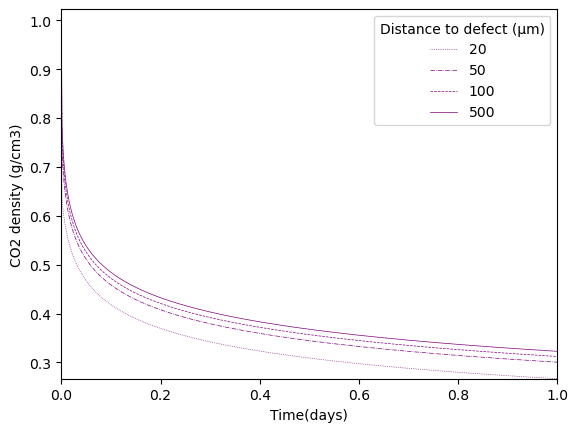

In [49]:
results_dict_surface['R0']['b0'].head()

linecolor='darkred'
linecolor2='orange'
seconds_in_e_year = 365.25 * 24 * 60 * 60


y_col='CO2_dens_gcm3'
x_col='Time(s)'
twin_col='Calculated depths (km)'

xlabel4plot='Time(years)'
ylabel4plot='CO2 density (g/cm3)'
twinlabel4plot='Calculated depth (km)'

linecolor='midnightblue'
linecolor2='purple'
linewidth=0.5

fig, ax = plt.subplots()

ax.plot(results_dict_surface['R0']['b0'][x_col]/day_in_sec,results_dict_surface['R0']['b0'][y_col],color=linecolor2,linestyle=':',linewidth=linewidth,label=str(round(b0*10**6)))
ax.plot(results_dict_surface['R0']['b1'][x_col]/day_in_sec,results_dict_surface['R0']['b1'][y_col],color=linecolor2,linestyle='-.',linewidth=linewidth,label=str(round(b1*10**6)))
ax.plot(results_dict_surface['R0']['b2'][x_col]/day_in_sec,results_dict_surface['R0']['b2'][y_col],color=linecolor2,linestyle='--', linewidth=linewidth,label=str(round(b2*10**6)))
ax.plot(results_dict_surface['R0']['b3'][x_col]/day_in_sec,results_dict_surface['R0']['b3'][y_col],color=linecolor2,linestyle='-',linewidth=linewidth, label=str(round(b3*10**6)))

xlim_F=([round(min(results_dict_surface['R0']['b0'][x_col]/day_in_sec)),round(max(results_dict_surface['R0']['b0'][x_col]/day_in_sec))])
ymin_F=np.nanmin([np.nanmin(results_dict_surface['R0']['b0'][y_col])])

ylim_F=[ymin_F,fi_rho_initial_gcm3]

ax.set_xlim(xlim_F)
ax.set_ylim(ylim_F)

ax.set_xlabel('Time(days)')
ax.set_ylabel(ylabel4plot)


ax.legend(title='Distance to defect (\u03BCm)')




In [29]:
ylim_F

[0.5358775078218901, 1.0]

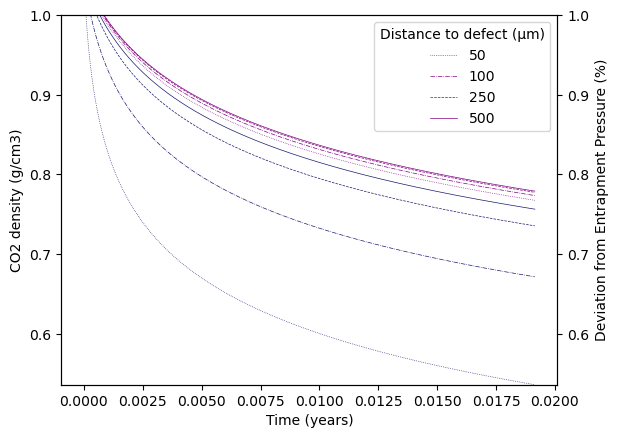

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Define some constants and variables
linecolor = 'darkred'
linecolor2 = 'orange'
seconds_in_e_year = 365.25 * 24 * 60 * 60
y_col = 'CO2_dens_gcm3'
x_col = 'Time(s)'
twin_col = 'Calculated depths (km)'
xlabel4plot = 'Time(years)'
ylabel4plot = 'CO2 density (g/cm3)'
twinlabel4plot = 'Calculated depth (km)'
linecolor = 'midnightblue'
linecolor2 = 'purple'
linewidth = 0.5

# Create a figure and axes
fig, ax = ax.subplots()

# Plot the data on the primary y-axis
ax.plot(results_dict_surface['R0']['b0'][x_col] / seconds_in_e_year, results_dict_surface['R0']['b0'][y_col], color=linecolor2, linestyle=':', linewidth=linewidth, label=str(round(b0 * 10 ** 6)))
ax.plot(results_dict_surface['R0']['b1'][x_col] / seconds_in_e_year, results_dict_surface['R0']['b1'][y_col], color=linecolor2, linestyle='-.', linewidth=linewidth, label=str(round(b1 * 10 ** 6)))
ax.plot(results_dict_surface['R0']['b2'][x_col] / seconds_in_e_year, results_dict_surface['R0']['b2'][y_col], color=linecolor2, linestyle='--', linewidth=linewidth, label=str(round(b2 * 10 ** 6)))
ax.plot(results_dict_surface['R0']['b3'][x_col] / seconds_in_e_year, results_dict_surface['R0']['b3'][y_col], color=linecolor2, linestyle='-', linewidth=linewidth, label=str(round(b3 * 10 ** 6)))

# Plot the data on the secondary y-axis

ax.plot(results_dict_surface['R0_2']['b4'][x_col] / seconds_in_e_year, results_dict_surface['R0_2']['b4'][y_col], color=linecolor, linestyle=':', linewidth=linewidth)
ax.plot(results_dict_surface['R0_2']['b5'][x_col] / seconds_in_e_year, results_dict_surface['R0_2']['b5'][y_col], color=linecolor, linestyle='-.', linewidth=linewidth)
ax.plot(results_dict_surface['R0_2']['b6'][x_col] / seconds_in_e_year, results_dict_surface['R0_2']['b6'][y_col], color=linecolor, linestyle='--', linewidth=linewidth)
ax.plot(results_dict_surface['R0_2']['b7'][x_col] / seconds_in_e_year, results_dict_surface['R0_2']['b7'][y_col], color=linecolor, linestyle='-', linewidth=linewidth)

ax2 = ax.twinx()
# Set the y-axis limits for both axes
ax.set_ylim([ymin_F, fi_rho_initial_gcm3])
ax2.set_ylim([ymin_F, fi_rho_initial_gcm3])

# Customize axis labels and legends
ax.set_xlabel('Time (years)')
ax.set_ylabel(ylabel4plot)
ax2.set_ylabel('Deviation from Entrapment Pressure (%)')

ax.legend(title='Distance to defect (μm)')

# Show the plot
ax.show()
